In this notebook, I will use word embeddings . First, I will train a model without using any pretrained embeddings, i.e., we will learn our own embeddings from the disaster tweets.  Then, I'll use pretrained GloVe, FastText and Paragram embeddings learned on a large data set

<h2>Load the data</h2>

In [2]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.shape, test.shape

((7613, 5), (3263, 4))

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<h2>Without pre-trained word embeddings</h2>

Let's create a model to learn our own embeddings and then make some predictions

<h3>Text Preprocessing</h3>

Preprocessing is going to be slightly different than what we did for simple logistic regression b/c for embeddings, context is important. So, for example, we'll keep numbers and stopwords because these could be useful

In [5]:
from bs4 import BeautifulSoup
import nltk
import re

def clean_text(text, remove_stopwords=False):
    # strip html tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # lower case, remove special characters, and strip leading and trailing whitespaces
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Create tokens
    words = text.lower().split()
    
    # filter out stopwords
    if remove_stopwords:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    return ' '.join(words)

train['clean_text'] = train['text'].apply(lambda x: clean_text(x))
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [6]:
test['clean_text'] = test['text'].apply(lambda x: clean_text(x))
test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


<h3>Split the data</h3>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train['clean_text'], train['target'], shuffle=True, test_size=0.2, random_state=0)
X_test = test['clean_text']

Later in the notebook, I will use pretrained embeddings using GloVe etc., but let's see how a model without pre-trained embeddings performs.  This is just to illustrate the power of pretrained embeddings

In [8]:
max(X_train.apply(lambda x: len(x)))

140

In [18]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialize parameters
np.random.seed(0)
input_length = 120 # max number of words to use in tweet
embed_size = 300 # embedding dimension for each word vector
max_features = 10000 # number of unique words to use

In [19]:
%%time

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Featurize
train_data_features = tokenizer.texts_to_sequences(X_train)
val_data_features = tokenizer.texts_to_sequences(X_val)
test_data_features = tokenizer.texts_to_sequences(X_test) 

# Pad sequences so they are all the same length
train_data_features = pad_sequences(train_data_features, maxlen=input_length)
val_data_features = pad_sequences(val_data_features, maxlen=input_length)
test_data_features = pad_sequences(test_data_features, maxlen=input_length)

Wall time: 308 ms


In [20]:
from keras.layers import Embedding, Dropout, Conv1D, MaxPool1D, Dense, \
    CuDNNLSTM, CuDNNGRU, Bidirectional
from keras.models import Sequential

def build_model(input_length, max_features, embed_size, use_lstm=False):
    model = Sequential()

    model.add(Embedding(
        input_dim=max_features, 
        output_dim=embed_size,
        input_length=input_length))

    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    
    if use_lstm:
        model.add(Bidirectional(CuDNNLSTM(128)))
    else:
        model.add(Bidirectional(CuDNNGRU(128)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

<b>BiGRU model on unigrams without pretrained embeddings</b>

In [21]:
gru_model = build_model(input_length, max_features, embed_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 300)          3000000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 120, 300)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 120, 32)           28832     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               124416    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

In [22]:
gru_history = gru_model.fit(train_data_features, y_train, batch_size=256, epochs=3, 
              validation_data=[val_data_features, y_val])

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 2s 390us/step - loss: 0.6629 - acc: 0.5841 - val_loss: 0.5884 - val_acc: 0.6940
Epoch 2/3
6090/6090 [==============================] - 1s 179us/step - loss: 0.4786 - acc: 0.7752 - val_loss: 0.4652 - val_acc: 0.7912
Epoch 3/3
6090/6090 [==============================] - 1s 179us/step - loss: 0.2813 - acc: 0.8872 - val_loss: 0.4662 - val_acc: 0.7971


In [23]:
import matplotlib.pyplot as plt

def plot_loss_curves(model):
    fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    
    # summarize history for accuracy
    axis1.plot(model.history['acc'], label='Train', linewidth=3)
    axis1.plot(model.history['val_acc'], label='Validation', linewidth=3)
    axis1.set_title('Model accuracy', fontsize=16)
    axis1.set_ylabel('accuracy')
    axis1.set_xlabel('epoch')
    axis1.legend(loc='upper left')

    # summarize history for loss
    axis2.plot(model.history['loss'], label='Train', linewidth=3)
    axis2.plot(model.history['val_loss'], label='Validation', linewidth=3)
    axis2.set_title('Model loss', fontsize=16)
    axis2.set_ylabel('loss')
    axis2.set_xlabel('epoch')
    axis2.legend(loc='upper right')
    plt.show()

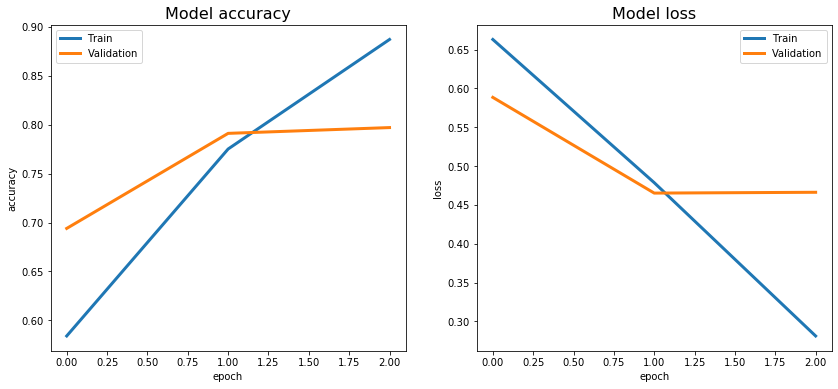

In [24]:
plot_loss_curves(gru_history)

In [26]:
from sklearn.metrics import f1_score, classification_report

y_val_probs_gru = gru_model.predict_proba(val_data_features)
for thresh in np.arange(0.2, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score(y_val, (y_val_probs_gru>thresh).astype(int))))

F1 score at threshold 0.2 is 0.7236315086782377
F1 score at threshold 0.21 is 0.7246963562753036
F1 score at threshold 0.22 is 0.728268309377139
F1 score at threshold 0.23 is 0.7337031900138696
F1 score at threshold 0.24 is 0.7363253856942497
F1 score at threshold 0.25 is 0.7390691114245416
F1 score at threshold 0.26 is 0.7409510290986515
F1 score at threshold 0.27 is 0.7421203438395415
F1 score at threshold 0.28 is 0.7490961677512654
F1 score at threshold 0.29 is 0.7478134110787172
F1 score at threshold 0.3 is 0.7533039647577092
F1 score at threshold 0.31 is 0.7511111111111112
F1 score at threshold 0.32 is 0.7531692766592095
F1 score at threshold 0.33 is 0.7544910179640719
F1 score at threshold 0.34 is 0.7526395173453997
F1 score at threshold 0.35 is 0.7482889733840304
F1 score at threshold 0.36 is 0.747135217723453
F1 score at threshold 0.37 is 0.7455803228285933
F1 score at threshold 0.38 is 0.7463377023901311
F1 score at threshold 0.39 is 0.7478665632273079
F1 score at threshold 0.

In [27]:
y_val_pred_gru = gru_model.predict_classes(val_data_features)
print(classification_report(y_val, y_val_pred_gru))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       886
           1       0.78      0.72      0.75       637

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [38]:
import gc, time
gc.collect(); time.sleep(3)

<b>BiLSTM model on unigrams without pretrained embeddings</b>

In [33]:
lstm_model = build_model(input_length, max_features, embed_size, use_lstm=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 300)          3000000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 120, 300)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 120, 32)           28832     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               165888    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

In [34]:
lstm_history = lstm_model.fit(train_data_features, y_train, batch_size=256, epochs=3, 
              validation_data=[val_data_features, y_val])

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 2s 404us/step - loss: 0.6747 - acc: 0.5665 - val_loss: 0.6210 - val_acc: 0.6481: 0s - loss: 0.6823 - acc: 0.
Epoch 2/3
6090/6090 [==============================] - 1s 196us/step - loss: 0.5739 - acc: 0.7345 - val_loss: 0.4994 - val_acc: 0.7899
Epoch 3/3
6090/6090 [==============================] - 1s 195us/step - loss: 0.3709 - acc: 0.8552 - val_loss: 0.4564 - val_acc: 0.8089


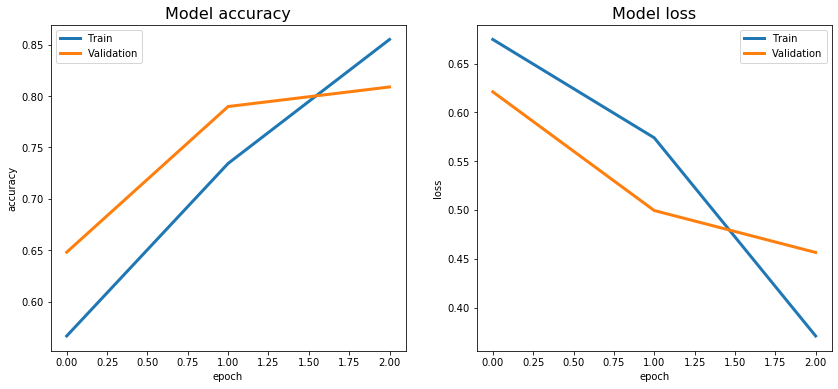

In [35]:
plot_loss_curves(lstm_history)

In [36]:
y_val_probs_lstm = lstm_model.predict_proba(val_data_features)
for thresh in np.arange(0.2, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score(y_val, (y_val_probs_lstm>thresh).astype(int))))

F1 score at threshold 0.2 is 0.7303370786516853
F1 score at threshold 0.21 is 0.7313961729270022
F1 score at threshold 0.22 is 0.7351040918880115
F1 score at threshold 0.23 is 0.738909090909091
F1 score at threshold 0.24 is 0.7403072421360644
F1 score at threshold 0.25 is 0.7453874538745388
F1 score at threshold 0.26 is 0.7498132935026139
F1 score at threshold 0.27 is 0.7496229260935144
F1 score at threshold 0.28 is 0.7484756097560976
F1 score at threshold 0.29 is 0.7486548808608763
F1 score at threshold 0.3 is 0.7507739938080495
F1 score at threshold 0.31 is 0.7527216174183516
F1 score at threshold 0.32 is 0.7547169811320755
F1 score at threshold 0.33 is 0.7531645569620254
F1 score at threshold 0.34 is 0.7513899920571883
F1 score at threshold 0.35 is 0.7527910685805422
F1 score at threshold 0.36 is 0.7529976019184652
F1 score at threshold 0.37 is 0.7538091419406575
F1 score at threshold 0.38 is 0.7526188557614827
F1 score at threshold 0.39 is 0.75
F1 score at threshold 0.4 is 0.747755

In [37]:
y_val_pred_lstm = lstm_model.predict_classes(val_data_features)
print(classification_report(y_val, y_val_pred_lstm))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       886
           1       0.82      0.70      0.75       637

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [39]:
gc.collect(); time.sleep(3)

<h2>With pre-trained embeddings</h2>

As is evident above, we don't have enough data for our own trained embeddings to be useful.  So, we will use pretrained embeddings from the following sources and see how the model performs. 
- GloVe embeddings from the Stanford NLP Projecs: Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download) available at https://nlp.stanford.edu/projects/glove/
- WikiNews FastText Embeddings: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens). Available at https://fasttext.cc/docs/en/english-vectors.html
- Paragram Embeddings. Available at https://cogcomp.org/page/resource_view/106



<h3>GloVe</h3>

Download the Twitter embeddings from https://nlp.stanford.edu/projects/glove/.  Let's get the embeddings and reformat them for our BiLSTM model. As stated in the description, the pretrained embeddings are of size 200d

In [64]:
f = open('data/glove.twitter.27B.200d.txt', 'r')
print(f.readline())
f.close()

<user> 0.31553 0.53765 0.10177 0.032553 0.003798 0.015364 -0.20344 0.33294 -0.20886 0.10061 0.30976 0.50015 0.32018 0.13537 0.0087039 0.1911 0.24668 -0.060752 -0.43623 0.019302 0.59972 0.13444 0.012801 -0.54052 0.27387 -1.182 -0.27677 0.11279 0.46596 -0.090685 0.24253 0.15654 -0.23618 0.57694 0.17563 -0.01969 0.018295 0.37569 -0.41984 0.22613 -0.20438 -0.076249 0.40356 0.61582 -0.10064 0.23318 0.22808 0.34576 -0.14627 -0.1988 0.033232 -0.84885 -0.25684 0.26369 0.29562 0.1847 -0.20668 -0.013297 0.12233 -0.47751 -0.17202 -0.14577 0.047446 -0.15824 0.054215 -0.19426 -0.081484 0.099009 0.10159 0.043571 0.50245 0.13362 0.065985 0.032969 -0.2017 -0.56905 -0.13203 0.073347 -0.063728 -0.2796 -0.38481 -0.020193 0.22298 -0.059115 0.045198 -0.13995 -0.13299 0.47309 -0.021874 0.38758 -0.074926 -0.0028093 -0.29829 -0.074987 -0.58542 -0.18065 -0.041805 0.41938 0.41004 -0.5911 0.10459 0.10724 0.69768 -0.15901 -0.059596 0.29368 -0.19609 0.39124 -0.29333 -0.0050833 -0.37854 0.33858 0.24782 0.29144 -0.2

Let's write a function to create an embedding matrix for each word.  This could take a while.  

In [65]:
%%time
import numpy as np

def get_embeddings(word, *arr): return word, np.asarray(arr, dtype='float32')
glove_embeddings = dict(get_embeddings(*v.split(' ')) 
                  for v in open('data/glove.twitter.27B.200d.txt', encoding='utf-8', errors='ignore')
                     if len(v)>100)

Wall time: 1min 11s


Now we can create an embedding matrix and a word list from embeddings.

In [66]:
%%time
embed_size = 200 # same dimension as the pretrained GloVe embeddings
glove_embedding_matrix = np.stack(list(glove_embeddings.values()))
glove_words = np.stack(list(glove_embeddings.keys()))

Wall time: 4.18 s


In [67]:
gc.collect(); time.sleep(3)

In [68]:
print('Number of words in the pre-trained embeddings:', len(glove_embedding_matrix))
print('Number of words in our disaster tweet dataset:', len(tokenizer.word_index))

Number of words in the pre-trained embeddings: 1193514
Number of words in our disaster tweet dataset: 18559


Here is the deal. Some of the words from our disaster tweet set are inevitably not going to be in the pretrained 1.2M set. For these words, we will sample our pretrained embeddings from a normal distribution with the same mean and standard deviation.  Otherwise, if the word exists, we will assign the embeddings from the pretrained embeddings

In [70]:
emb_mean, emb_std = glove_embedding_matrix.mean(), glove_embedding_matrix.std()

# Initialize the embedding matrix with a random sampling
tweet_embedding_matrix = np.random.normal(emb_mean, emb_std, (len(tokenizer.word_index), embed_size))

for word, idx in tokenizer.word_index.items():
    if idx >= max_features: continue
    
    # Get the embeddings. If the word is not present, the 'get' attribute of the dictionary will return 'None'
    embedding_vector = glove_embeddings.get(word)
    
    # If not None, assign the pretrained embedding to that word
    if embedding_vector is not None: tweet_embedding_matrix[idx] = embedding_vector

tweet_embedding_matrix.shape

(18559, 200)

In [71]:
tweet_embedding_matrix

array([[ 0.28705916,  0.35818458, -0.41253924, ...,  0.25524504,
        -0.38548503,  0.27000984],
       [ 0.15491   ,  0.10617   , -0.23609   , ..., -0.43167001,
        -0.36938   , -0.20468   ],
       [-0.11691   , -0.061485  , -0.46395999, ..., -0.080032  ,
        -0.4894    , -0.52283001],
       ...,
       [-0.90258841,  0.07369912, -0.57129641, ..., -0.51927589,
        -0.34590157, -0.12202445],
       [ 0.63434447,  0.06408276,  0.49237777, ..., -0.12770484,
         0.02668755,  0.59381193],
       [ 0.374434  , -0.36851769, -0.26297388, ...,  0.63011018,
        -0.23994364, -0.02246314]])

In [72]:
gc.collect(); time.sleep(3)

In [108]:
def build_pre_embed_model(embedding_matrix, input_length, use_lstm=False):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        input_length = input_length,
        weights = [embedding_matrix],
        trainable = False))
    
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    
    if use_lstm:
        model.add(Bidirectional(CuDNNLSTM(128)))
    else:
        model.add(Bidirectional(CuDNNGRU(128)))

    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [82]:
glove_model = build_pre_embed_model(embedding_matrix=tweet_embedding_matrix, 
                                    input_length=input_length, use_lstm=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 120, 200)          3711800   
_________________________________________________________________
dropout_22 (Dropout)         (None, 120, 200)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 120, 32)           19232     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               165888    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total para

In [83]:
glove_history = glove_model.fit(train_data_features, y_train, batch_size=256, epochs=10, 
                    validation_data=[val_data_features, y_val])

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 2s 378us/step - loss: 0.6287 - acc: 0.6365 - val_loss: 0.5060 - val_acc: 0.7577
Epoch 2/10
6090/6090 [==============================] - 1s 128us/step - loss: 0.4835 - acc: 0.7790 - val_loss: 0.4517 - val_acc: 0.7925
Epoch 3/10
6090/6090 [==============================] - 1s 128us/step - loss: 0.4426 - acc: 0.8038 - val_loss: 0.4446 - val_acc: 0.8102
Epoch 4/10
6090/6090 [==============================] - 1s 128us/step - loss: 0.4271 - acc: 0.8079 - val_loss: 0.4339 - val_acc: 0.8102
Epoch 5/10
6090/6090 [==============================] - 1s 129us/step - loss: 0.4131 - acc: 0.8136 - val_loss: 0.4350 - val_acc: 0.8096
Epoch 6/10
6090/6090 [==============================] - 1s 129us/step - loss: 0.4015 - acc: 0.8218 - val_loss: 0.4421 - val_acc: 0.8129
Epoch 7/10
6090/6090 [==============================] - 1s 129us/step - loss: 0.3929 - acc: 0.8302 - val_loss: 0.4392 - val_acc: 0.8004


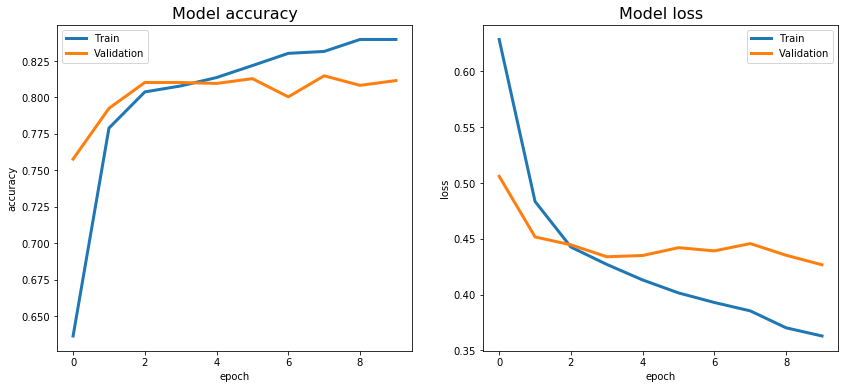

In [85]:
plot_loss_curves(glove_history)

In [86]:
y_val_pred_glove = glove_model.predict_classes(val_data_features)
print(classification_report(y_val, y_val_pred_glove))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       886
           1       0.82      0.70      0.76       637

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [87]:
y_val_probs_glove = glove_model.predict_proba(val_data_features)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print('F1 score at threshold {0} is {1}'.format(thresh, f1_score(y_val, y_val_probs_glove>thresh)))

F1 score at threshold 0.2 is 0.7366310160427808
F1 score at threshold 0.21 is 0.7391304347826086
F1 score at threshold 0.22 is 0.7443142660234322
F1 score at threshold 0.23 is 0.7463312368972747
F1 score at threshold 0.24 is 0.7450704225352113
F1 score at threshold 0.25 is 0.7501779359430605
F1 score at threshold 0.26 is 0.7525179856115107
F1 score at threshold 0.27 is 0.7514450867052024
F1 score at threshold 0.28 is 0.7538349159970781
F1 score at threshold 0.29 is 0.7583148558758316
F1 score at threshold 0.3 is 0.7664670658682636
F1 score at threshold 0.31 is 0.7650602409638554
F1 score at threshold 0.32 is 0.7659574468085107
F1 score at threshold 0.33 is 0.7667682926829268
F1 score at threshold 0.34 is 0.7653374233128835
F1 score at threshold 0.35 is 0.7657935285053928
F1 score at threshold 0.36 is 0.7710280373831776
F1 score at threshold 0.37 is 0.7717647058823529
F1 score at threshold 0.38 is 0.7680126682501979
F1 score at threshold 0.39 is 0.7750200160128102
F1 score at threshold 

Maximum F1 score using GloVe is 0.775 at a threshold of 0.39

In [88]:
gc.collect(); time.sleep(3)

<h3>WikiNews FastText Embeddings</h3>

As opposed to GloVe (or Word2Vec), which use each word as the smallest unit for training, FastText uses n-gram characters as the smallest unit. For example, the word vector ,"climb", can be broken down into separate word vectors units as "cl","cli","clim" "climb".  FastText can generate better word embeddings for rare words, or even words not seen during training because the n-gram character vectors are shared with other words. This is something that Word2Vec and GLOVE cannot achieve.

Download the wiki-news-300d-1M embeddings from https://fasttext.cc/docs/en/english-vectors.html.  We'll do pretty much the same thing as we did for pretrained GloVe embeddings with some minor modifications. 

In [89]:
f = open('data/wiki-news-300d-1M.vec', 'r')
print(f.readline())
print(f.readline())
f.close()

999994 300

, 0.1073 0.0089 0.0006 0.0055 -0.0646 -0.0600 0.0450 -0.0133 -0.0357 0.0430 -0.0356 -0.0032 0.0073 -0.0001 0.0258 -0.0166 0.0075 0.0686 0.0392 0.0753 0.0115 -0.0087 0.0421 0.0265 -0.0601 0.2420 0.0199 -0.0739 -0.0031 -0.0263 -0.0062 0.0168 -0.0357 -0.0249 0.0190 -0.0184 -0.0537 0.1420 0.0600 0.0226 -0.0038 -0.0675 -0.0036 -0.0080 0.0570 0.0208 0.0223 -0.0256 -0.0153 0.0022 -0.0482 0.0131 -0.6016 -0.0088 0.0106 0.0229 0.0336 0.0071 0.0887 0.0237 -0.0290 -0.0405 -0.0125 0.0147 0.0475 0.0647 0.0474 0.0199 0.0408 0.0322 0.0036 0.0350 -0.0723 -0.0305 0.0184 -0.0026 0.0240 -0.0160 -0.0308 0.0434 0.0147 -0.0457 -0.0267 -0.1703 -0.0099 0.0417 0.0235 -0.0260 -0.1519 -0.0116 -0.0306 -0.0413 0.0330 0.0723 0.0365 -0.0001 0.0042 0.0346 0.0277 -0.0305 0.0784 -0.0404 0.0187 -0.0225 -0.0206 -0.0179 -0.2428 0.0669 0.0523 0.0527 0.0149 -0.0708 -0.0987 0.0263 -0.0611 0.0302 0.0216 0.0313 -0.0140 -0.2495 -0.0346 -0.0480 0.0250 0.2130 -0.0330 -0.1553 -0.0292 -0.0346 0.1074 0.0010 -0.0117 -0.005

Let's write a function to create an embedding matrix for each word.

In [91]:
%%time
import numpy as np

def get_embeddings(word, *arr): return word, np.asarray(arr, dtype='float32')
fasttext_embeddings = dict(get_embeddings(*v.split(' ')) 
                  for v in open('data/wiki-news-300d-1M.vec', encoding='utf-8', errors='ignore') 
                     if len(v)>100)

Wall time: 1min 22s


Now we can create an embedding matrix and a word list from embeddings. This will also take a while

In [92]:
%%time
embed_size = 300 # same dimension as the pretrained embeddings
fasttext_embedding_matrix = np.stack(list(fasttext_embeddings.values())) 
fasttext_words = np.stack(list(fasttext_embeddings.keys()))

Wall time: 3.5 s


In [94]:
print('Number of words in the pre-trained embeddings:', len(fasttext_embedding_matrix))
print('Number of words in our disaster tweet dataset:', len(tokenizer.word_index))

Number of words in the pre-trained embeddings: 999994
Number of words in our disaster tweet dataset: 18559


In [98]:
emb_mean, emb_std = fasttext_embedding_matrix.mean(), fasttext_embedding_matrix.std()

# Initialize the embedding matrix with a random sampling
tweet_embedding_matrix = np.random.normal(emb_mean, emb_std, (len(tokenizer.word_index), embed_size))
for word, idx in tokenizer.word_index.items():
    if idx >= max_features: continue
    
    # Get the embeddings. If the word is not present, the 'get' attribute of the dictionary will return 'None'
    embedding_vector = fasttext_embeddings.get(word)
    
    # If not None, assign the pretrained embedding to that word
    if embedding_vector is not None: tweet_embedding_matrix[idx] = embedding_vector

tweet_embedding_matrix.shape

(18559, 300)

In [113]:
fasttext_model = build_pre_embed_model(embedding_matrix=tweet_embedding_matrix, 
                         input_length=input_length, use_lstm=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 120, 300)          5567700   
_________________________________________________________________
dropout_34 (Dropout)         (None, 120, 300)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 120, 32)           28832     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256)               165888    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total para

In [114]:
fasttext_history = fasttext_model.fit(train_data_features, y_train, batch_size=256, epochs=10, 
                    validation_data=[val_data_features, y_val])

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 3s 511us/step - loss: 0.6565 - acc: 0.5977 - val_loss: 0.5779 - val_acc: 0.7137
Epoch 2/10
6090/6090 [==============================] - 1s 144us/step - loss: 0.5230 - acc: 0.7502 - val_loss: 0.4830 - val_acc: 0.7728
Epoch 3/10
6090/6090 [==============================] - 1s 144us/step - loss: 0.4538 - acc: 0.7966 - val_loss: 0.4434 - val_acc: 0.8070
Epoch 4/10
6090/6090 [==============================] - 1s 145us/step - loss: 0.4264 - acc: 0.8115 - val_loss: 0.4307 - val_acc: 0.8030
Epoch 5/10
6090/6090 [==============================] - 1s 144us/step - loss: 0.4123 - acc: 0.8187 - val_loss: 0.4212 - val_acc: 0.8102
Epoch 6/10
6090/6090 [==============================] - 1s 144us/step - loss: 0.4025 - acc: 0.8240 - val_loss: 0.4195 - val_acc: 0.8076
Epoch 7/10
6090/6090 [==============================] - 1s 144us/step - loss: 0.3962 - acc: 0.8307 - val_loss: 0.4254 - val_acc: 0.8056


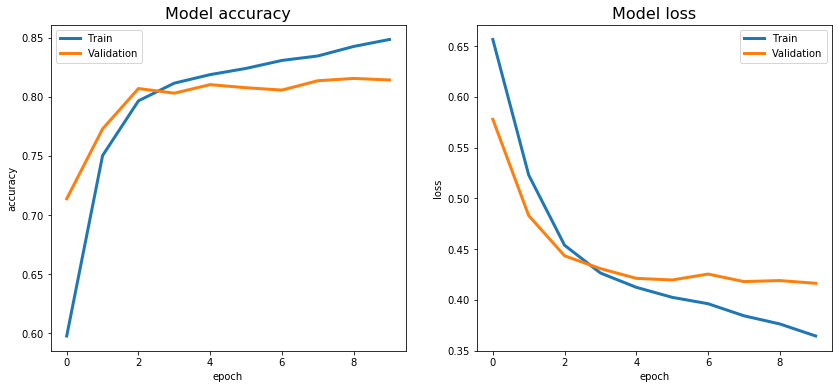

In [115]:
plot_loss_curves(fasttext_history)

In [116]:
y_val_pred_fasttext = fasttext_model.predict_classes(val_data_features)
print(classification_report(y_val, y_val_pred_fasttext))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       886
           1       0.87      0.65      0.75       637

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [117]:
y_val_probs_fasttext = fasttext_model.predict_proba(val_data_features)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print('F1 score at threshold {0} is {1}'.format(thresh, f1_score(y_val, y_val_probs_fasttext>thresh)))

F1 score at threshold 0.2 is 0.7536231884057971
F1 score at threshold 0.21 is 0.7594936708860759
F1 score at threshold 0.22 is 0.7658045977011494
F1 score at threshold 0.23 is 0.767559739319334
F1 score at threshold 0.24 is 0.7661764705882353
F1 score at threshold 0.25 is 0.7719821162444113
F1 score at threshold 0.26 is 0.7723516153268218
F1 score at threshold 0.27 is 0.770053475935829
F1 score at threshold 0.28 is 0.7729022324865281
F1 score at threshold 0.29 is 0.7736434108527133
F1 score at threshold 0.3 is 0.7727272727272727
F1 score at threshold 0.31 is 0.7715415019762847
F1 score at threshold 0.32 is 0.7710651828298886
F1 score at threshold 0.33 is 0.7733118971061093
F1 score at threshold 0.34 is 0.7743506493506495
F1 score at threshold 0.35 is 0.772875816993464
F1 score at threshold 0.36 is 0.7699917559769167
F1 score at threshold 0.37 is 0.7684647302904565
F1 score at threshold 0.38 is 0.7644593461860855
F1 score at threshold 0.39 is 0.7618243243243243
F1 score at threshold 0.4

Maximum F1 score using FastText is 0.774 at a threshold of 0.29

In [118]:
gc.collect(); time.sleep(3)

<h3>Paragram Embeddings</h3>

In [119]:
f = open('data/paragram_300_sl999.txt', 'r')
print(f.readline())
f.close()

, -0.257125788774 0.809895659891 0.00352934730227 -0.261192139319 0.0475149130921 0.31447672109 0.282113045078 -0.308695022335 -0.307101047699 1.9226355407 -0.222033484854 0.24893029427 0.238734438728 -0.171986103109 -0.513283578576 0.00616461951274 -0.109530471451 1.55904316215 -0.0622845318458 0.054242491735 -0.0587660591309 0.051181797445 -0.000436753397368 -0.393734510549 0.113699988029 -0.206368505165 0.111778509742 0.094304986534 0.527331864307 -0.184620014155 0.228430702474 0.0416477851414 -0.115934728255 0.282809443813 0.584579772995 -0.0475815430781 0.218655725173 -0.0159711145264 -0.184448274772 0.291061497788 -0.0623817338328 -0.331140302287 0.0833015222404 0.0060065082742 -0.118001313175 0.0114101281466 -0.301397683421 0.155064814567 0.247375429911 0.0104703282316 0.117448779329 0.293554545694 -0.0849206293849 0.0628167357461 -0.484696455189 0.00573283599985 0.235655442401 -0.16885329547 0.269412322296 0.129659711866 -0.0923916881997 0.0912989873214 0.274665827254 0.1618788

In [120]:
%%time
def get_embeddings(word, *arr): return word, np.asarray(arr, dtype='float32')
paragram_embeddings = dict(get_embeddings(*v.split(' ')) 
                  for v in open('data/paragram_300_sl999.txt', encoding='utf-8', errors='ignore')
                     if len(v)>100)

Wall time: 2min 25s


In [121]:
%%time
embed_size = 300
paragram_embedding_matrix = np.stack(list(paragram_embeddings.values()))
paragram_words = np.stack(list(paragram_embeddings.keys()))

Wall time: 48.1 s


In [122]:
print('Number of words in the pre-trained embeddings:', len(paragram_embeddings))
print('Number of words in our disaster tweet dataset:', len(tokenizer.word_index))

Number of words in the pre-trained embeddings: 1703755
Number of words in our disaster tweet dataset: 18559


In [123]:
emb_mean, emb_std = paragram_embedding_matrix.mean(), paragram_embedding_matrix.std()

# Initialize the embedding matrix with a random sampling
tweet_embedding_matrix = np.random.normal(emb_mean, emb_std, (len(tokenizer.word_index), embed_size))
for word, idx in tokenizer.word_index.items():
    if idx >= max_features: continue
    
    # Get the embeddings. If the word is not present, the 'get' attribute of the dictionary will return 'None'
    embedding_vector = paragram_embeddings.get(word)
    
    # If not None, assign the pretrained embedding to that word
    if embedding_vector is not None: tweet_embedding_matrix[idx] = embedding_vector

tweet_embedding_matrix.shape

(18559, 300)

In [131]:
paragram_model = build_pre_embed_model(embedding_matrix=tweet_embedding_matrix, 
                         input_length=input_length, use_lstm=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 120, 300)          5567700   
_________________________________________________________________
dropout_42 (Dropout)         (None, 120, 300)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 120, 32)           28832     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 256)               165888    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total para

In [132]:
paragram_history = paragram_model.fit(train_data_features, y_train, batch_size=256, epochs=5, 
                    validation_data=[val_data_features, y_val])

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 4s 615us/step - loss: 0.6292 - acc: 0.6443 - val_loss: 0.5174 - val_acc: 0.7656
Epoch 2/5
6090/6090 [==============================] - 1s 146us/step - loss: 0.4848 - acc: 0.7772 - val_loss: 0.4581 - val_acc: 0.8017
Epoch 3/5
6090/6090 [==============================] - 1s 146us/step - loss: 0.4360 - acc: 0.8077 - val_loss: 0.4731 - val_acc: 0.7938
Epoch 4/5
6090/6090 [==============================] - 1s 147us/step - loss: 0.4138 - acc: 0.8169 - val_loss: 0.4372 - val_acc: 0.8089
Epoch 5/5
6090/6090 [==============================] - 1s 147us/step - loss: 0.3853 - acc: 0.8335 - val_loss: 0.4370 - val_acc: 0.8168


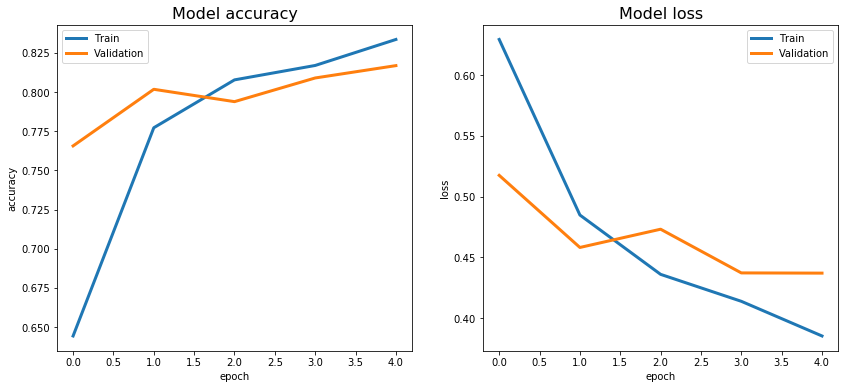

In [133]:
plot_loss_curves(paragram_history)

In [135]:
y_val_pred_paragram = paragram_model.predict_classes(val_data_features)
print(classification_report(y_val, y_val_pred_paragram))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       886
           1       0.83      0.70      0.76       637

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



In [136]:
y_val_probs_paragram = paragram_model.predict_proba(val_data_features)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print('F1 score at threshold {0} is {1}'.format(thresh, f1_score(y_val, y_val_probs_paragram>thresh)))

F1 score at threshold 0.2 is 0.7382550335570469
F1 score at threshold 0.21 is 0.7465753424657534
F1 score at threshold 0.22 is 0.7463718037318589
F1 score at threshold 0.23 is 0.7478991596638657
F1 score at threshold 0.24 is 0.7469707769066287
F1 score at threshold 0.25 is 0.7536023054755042
F1 score at threshold 0.26 is 0.75254730713246
F1 score at threshold 0.27 is 0.7538574577516534
F1 score at threshold 0.28 is 0.7561156412157153
F1 score at threshold 0.29 is 0.7574850299401198
F1 score at threshold 0.3 is 0.7601809954751132
F1 score at threshold 0.31 is 0.7579908675799089
F1 score at threshold 0.32 is 0.76036866359447
F1 score at threshold 0.33 is 0.7632398753894082
F1 score at threshold 0.34 is 0.766223612197029
F1 score at threshold 0.35 is 0.7666928515318148
F1 score at threshold 0.36 is 0.7624309392265194
F1 score at threshold 0.37 is 0.7617529880478088
F1 score at threshold 0.38 is 0.7606084867894316
F1 score at threshold 0.39 is 0.7626709573612229
F1 score at threshold 0.4 i

Maximum F1 score using Paragram is 0.767 at a threshold of 0.41

In [137]:
gc.collect(); time.sleep(3)

<h3>Blended Model</h3>

Since GloVe, FastText and Paragram embeddings are trained using different principles, it's possible that they learned different things and that a blended model provides better predictions

In [139]:
y_val_probs_blend = 0.34*y_val_probs_glove + 0.33*y_val_probs_fasttext + 0.33*y_val_probs_paragram
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score(y_val, (y_val_probs_blend>thresh).astype(int))))

F1 score at threshold 0.1 is 0.6529100529100529
F1 score at threshold 0.11 is 0.6673936750272628
F1 score at threshold 0.12 is 0.6804932735426009
F1 score at threshold 0.13 is 0.6896948762233737
F1 score at threshold 0.14 is 0.6975381008206331
F1 score at threshold 0.15 is 0.7082833133253302
F1 score at threshold 0.16 is 0.720887245841035
F1 score at threshold 0.17 is 0.7285266457680251
F1 score at threshold 0.18 is 0.731016731016731
F1 score at threshold 0.19 is 0.7373935821872954
F1 score at threshold 0.2 is 0.7416331994645248
F1 score at threshold 0.21 is 0.7462686567164178
F1 score at threshold 0.22 is 0.7529249827942189
F1 score at threshold 0.23 is 0.7549019607843137
F1 score at threshold 0.24 is 0.7642857142857142
F1 score at threshold 0.25 is 0.7690079652425778
F1 score at threshold 0.26 is 0.7690058479532164
F1 score at threshold 0.27 is 0.7743362831858406
F1 score at threshold 0.28 is 0.7762081784386617
F1 score at threshold 0.29 is 0.7747747747747746
F1 score at threshold 0.

Maximum F1 score using the blended model is 0.781 at a threshold of 0.42, which is indeed higher than the three individual models. It also outperforms the models without pretrained embeddings. We can now use the blended model to make some predictions on the test set

In [143]:
y_test_probs_glove = glove_model.predict_proba(test_data_features)
y_test_probs_fasttext = fasttext_model.predict_proba(test_data_features)
y_test_probs_paragram = paragram_model.predict_proba(test_data_features)

y_test_probs = 0.34*y_test_probs_glove + 0.33*y_test_probs_fasttext + 0.33*y_test_probs_paragram
y_test_preds = (y_test_probs>0.42)*1
y_test_preds.mean()

0.37174379405455105

The blended model predicts that roughly 37% are disaster tweets

In [144]:
test['target'] = y_test_preds
test[['id', 'target']].to_csv('data/submission_pretrained.csv', index=False)